# F6 Week 3 - Conditional SVM→GP Strategy

## Strategy: Test SVM Reliability, Then Decide

**Week 2 Analysis:**
- Input: [0.410, 0.299, 0.510, 0.814, 0.072]
- Output: -0.237 (RANK 1! 🥇)
- Pattern: X5 near boundary (0.072), X4 high (0.814)
- n/p = 21/5 = 4.2 (LOW - SVM questionable!)

**Week 3 Strategy:**
- TEST SVM first
- If cross validation, CV ≥ 60%: Use Sequential (50/50)
- If CV < 60%: Use Pure GP (30% local)
- Adaptive based on SVM reliability!

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
function_number = 6
sns.set_style('whitegrid')
print('='*70)
print('F6 WEEK 3: CONDITIONAL STRATEGY')
print('='*70)
print('\nWeek 2: RANK 1 (-0.237)')
print('n/p = 4.2 (LOW!) → Test SVM first!')

F6 WEEK 3: CONDITIONAL STRATEGY

Week 2: RANK 1 (-0.237)
n/p = 4.2 (LOW!) → Test SVM first!


In [38]:
X = np.load('f6_W3_inputs.npy')
Y = np.load('f6_W3_outputs.npy')

print(f'Data: {len(X)} samples, {X.shape[1]}D')
print(f'Best: {Y.max():.6f}')
print(f'n/p: {len(X)/X.shape[1]:.2f} (questionable for SVM!)')

week2_idx = np.argmax(Y)
week2_point = X[week2_idx]
week2_value = Y[week2_idx]

Data: 22 samples, 5D
Best: -0.237202
n/p: 4.40 (questionable for SVM!)


## STEP 1: Test SVM Reliability

In [39]:
threshold = np.percentile(Y, 70)
y_binary = (Y > threshold).astype(int)

svm = SVC(kernel='linear', C=0.5, probability=True, random_state=42)
svm.fit(X, y_binary)
cv_scores = cross_val_score(svm, X, y_binary, cv=3)
svm_cv = cv_scores.mean()

print('='*70)
print('SVM RELIABILITY TEST')
print('='*70)
print(f'\nCV Accuracy: {svm_cv:.1%} ± {cv_scores.std():.1%}')

USE_SVM = svm_cv >= 0.60

if USE_SVM:
    print(f'\n✓ CV ≥ 60% → USE SVM FILTERING')
    print(f'  Strategy: 50% SVM + 50% boundary')
    STRATEGY = 'SEQUENTIAL'
else:
    print(f'\n⚠️  CV < 60% → SKIP SVM')
    print(f'  Strategy: Pure GP with 30% local focus')
    STRATEGY = 'PURE_GP'

weights = svm.coef_[0]
print(f'\nSVM Weights:')
for i, w in enumerate(weights):
    print(f'  X{i+1}: {w:+.3f}')

SVM RELIABILITY TEST

CV Accuracy: 68.5% ± 4.2%

✓ CV ≥ 60% → USE SVM FILTERING
  Strategy: 50% SVM + 50% boundary

SVM Weights:
  X1: -0.177
  X2: -0.021
  X3: +0.083
  X4: +0.232
  X5: -0.299


In [40]:
kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True, random_state=42)
gp.fit(X, Y)
print(f'GP R²: {gp.score(X, Y):.3f}')

GP R²: 1.000


## STEP 2: Generate Candidates (Adaptive)

In [41]:
np.random.seed(42)

if STRATEGY == 'SEQUENTIAL':
    print('\nUsing SEQUENTIAL strategy...')
    
    X_global = np.random.uniform(0, 1, (10000, 5))
    svm_pred = svm.predict(X_global)
    svm_prob = svm.predict_proba(X_global)[:, 1]
    
    # 50% SVM
    if (svm_pred == 1).sum() > 0:
        svm_idx = np.where(svm_pred == 1)[0]
        X_svm = X_global[svm_idx[:min(5000, len(svm_idx))]]
    else:
        top_idx = np.argsort(svm_prob)[::-1][:5000]
        X_svm = X_global[top_idx]
    
    # 50% boundary
    X_boundary = []
    while len(X_boundary) < 5000:
        c = np.random.uniform(0, 1, 5)
        if (c < 0.1).any() or (c > 0.9).any():
            X_boundary.append(c)
    X_boundary = np.array(X_boundary[:5000])
    
    X_filtered = np.vstack([X_svm, X_boundary])
    print(f'  SVM: {len(X_svm):,}')
    print(f'  Boundary: {len(X_boundary):,}')
    
else:  # PURE_GP
    print('\nUsing PURE GP strategy (30% local)...')
    
    # 30% local
    local_std = 0.15
    X_local = []
    for _ in range(3000):
        c = week2_point + np.random.normal(0, local_std, 5)
        c = np.clip(c, 0, 1)
        X_local.append(c)
    X_local = np.array(X_local)
    
    # 20% boundary
    X_boundary = []
    while len(X_boundary) < 2000:
        c = np.random.uniform(0, 1, 5)
        if (c < 0.1).any() or (c > 0.9).any():
            X_boundary.append(c)
    X_boundary = np.array(X_boundary[:2000])
    
    # 50% random
    X_random = np.random.uniform(0, 1, (5000, 5))
    
    X_filtered = np.vstack([X_local, X_boundary, X_random])
    print(f'  Local: {len(X_local):,}')
    print(f'  Boundary: {len(X_boundary):,}')
    print(f'  Random: {len(X_random):,}')

print(f'\nTotal candidates: {len(X_filtered):,}')


Using SEQUENTIAL strategy...
  SVM: 5,000
  Boundary: 5,000

Total candidates: 10,000


In [42]:
def expected_improvement(X_new, gp, y_best, xi=0.1):
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei

y_best = Y.max()
ei_values = expected_improvement(X_filtered, gp, y_best, xi=0.1)
mu_all, sigma_all = gp.predict(X_filtered, return_std=True)

best_idx = np.argmax(ei_values)
x_next = X_filtered[best_idx]
mu_next = mu_all[best_idx]
sigma_next = sigma_all[best_idx]
ei_next = ei_values[best_idx]

print('='*70)
print(f'WEEK 3 RECOMMENDATION ({STRATEGY})')
print('='*70)
print(f'\nPoint: {x_next}')
print(f'Predicted: {mu_next:.6f} ± {sigma_next:.6f}')
print(f'Expected gain: {((mu_next/y_best-1)*100):+.2f}%')

if STRATEGY == 'PURE_GP':
    distance = np.linalg.norm(x_next - week2_point)
    print(f'\nDistance from W2: {distance:.3f}')

WEEK 3 RECOMMENDATION (SEQUENTIAL)

Point: [0.21147111 0.06109003 0.45513069 0.90552021 0.00403042]
Predicted: -0.340409 ± 0.262830
Expected gain: +43.51%


Creating acquisition curves for F6...


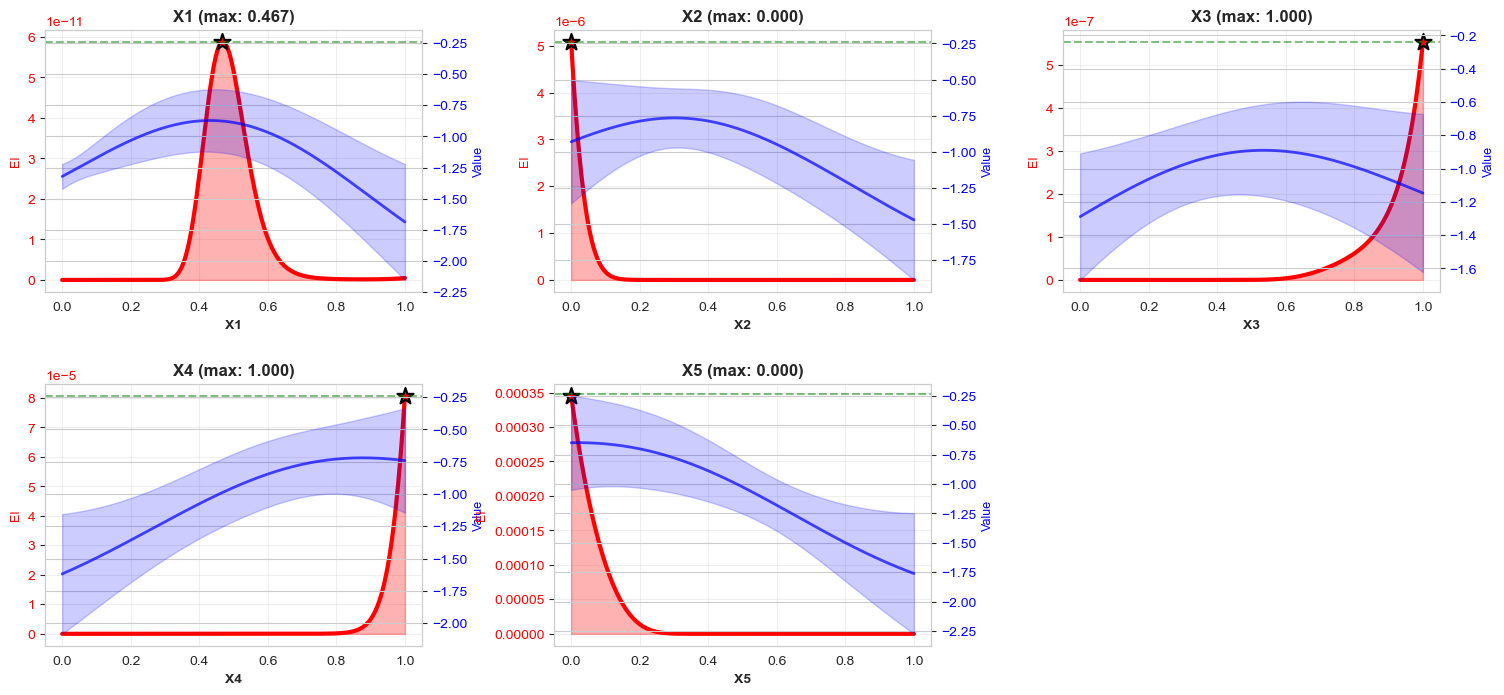

✓ Saved!


In [43]:
print(f'Creating acquisition curves for F{function_number}...')

# Get dimensions from data
n_dims = X.shape[1]

# Calculate grid size
n_cols = 3
n_rows = (n_dims + n_cols - 1) // n_cols  # Ceiling division

fig = plt.figure(figsize=(18, 4 * n_rows))
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.35)

for dim in range(n_dims):  # ✅ Correct for any function!
    ax = fig.add_subplot(gs[dim // n_cols, dim % n_cols])
    ax2 = ax.twinx()
    
    x1 = np.linspace(0, 1, 200)
    Xt = np.tile(X.mean(axis=0), (200, 1))
    Xt[:, dim] = x1
    
    m, s = gp.predict(Xt, return_std=True)
    e = expected_improvement(Xt, gp, y_best, 0.1)
    
    # GP plot
    ax2.plot(x1, m, 'b-', lw=2, alpha=0.7)
    ax2.fill_between(x1, m - 2*s, m + 2*s, alpha=0.2, color='blue')
    ax2.axhline(y_best, color='green', ls='--', alpha=0.5)
    ax2.set_ylabel('Value', color='blue', fontsize=9)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # EI plot
    ax.plot(x1, e, 'r-', lw=3)
    ax.fill_between(x1, 0, e, alpha=0.3, color='red')
    
    mi = np.argmax(e)
    ax.scatter(x1[mi], e[mi], color='red', s=150, marker='*', 
              zorder=5, edgecolors='black', lw=1.5)
    
    ax.set_xlabel(f'X{dim+1}', fontweight='bold')
    ax.set_ylabel('EI', color='red', fontsize=9)
    ax.set_title(f'X{dim+1} (max: {x1[mi]:.3f})', fontweight='bold')
    ax.tick_params(axis='y', labelcolor='red')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'Capstone_F{function_number}_W3_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved!')

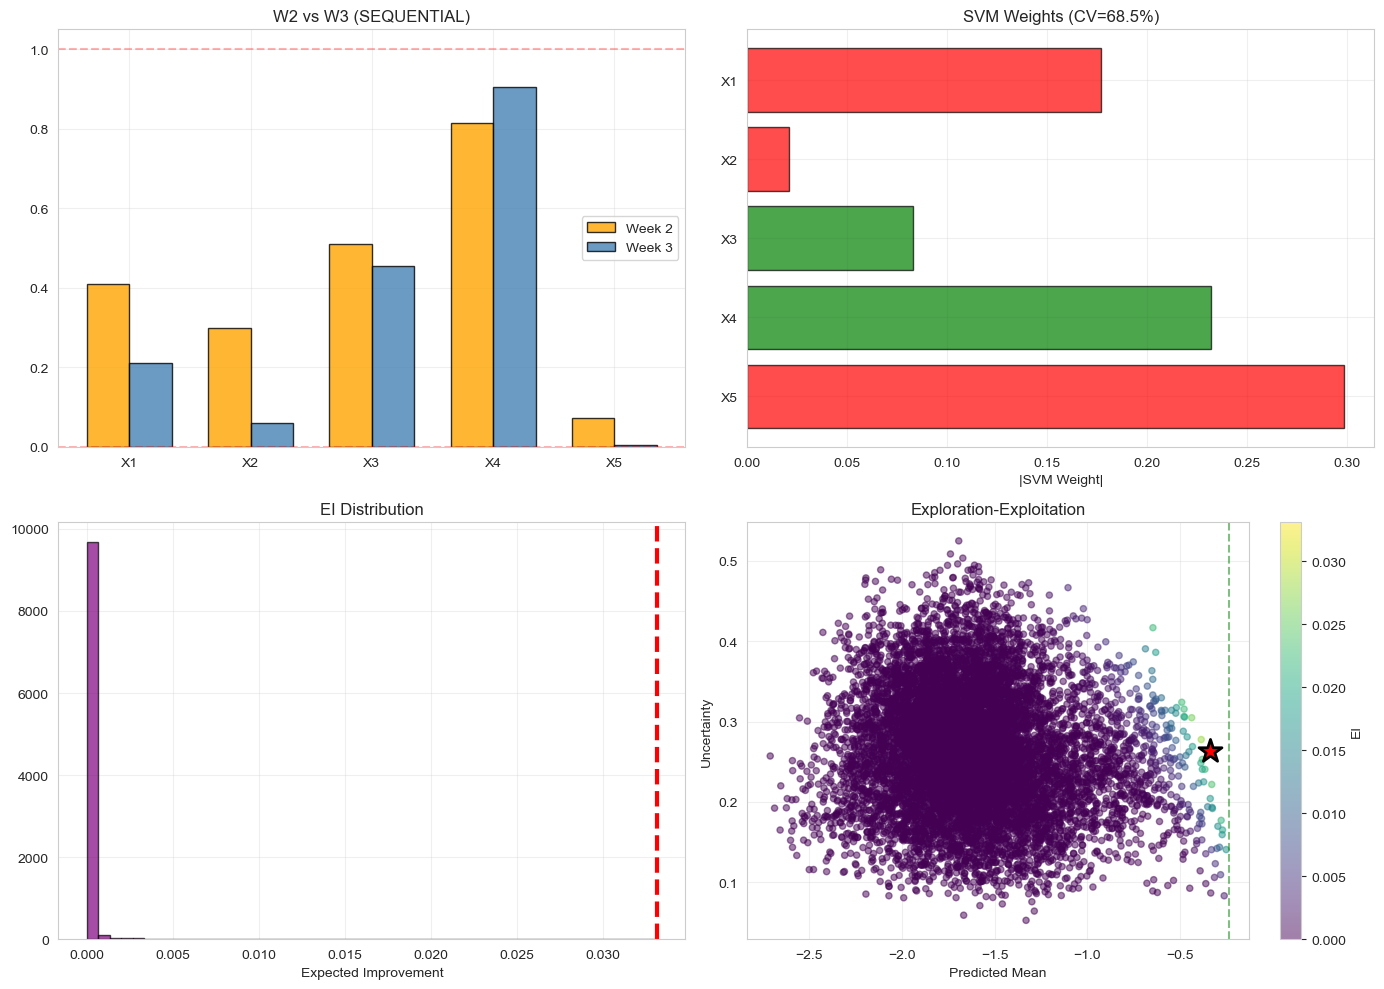

✓ Saved: f6_w3_results.png


In [44]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# W2 vs W3
ax = axes[0, 0]
dims = np.arange(5)
width = 0.35
ax.bar(dims - width/2, week2_point, width, label='Week 2', alpha=0.8, color='orange', edgecolor='black')
ax.bar(dims + width/2, x_next, width, label='Week 3', alpha=0.8, color='steelblue', edgecolor='black')
ax.axhline(0, color='red', linestyle='--', alpha=0.3)
ax.axhline(1, color='red', linestyle='--', alpha=0.3)
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.set_title(f'W2 vs W3 ({STRATEGY})')
ax.legend()
ax.grid(alpha=0.3)

# SVM weights
ax = axes[0, 1]
colors = ['green' if w > 0 else 'red' for w in weights]
ax.barh(dims, np.abs(weights), color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(dims)
ax.set_yticklabels([f'X{i+1}' for i in dims])
ax.set_xlabel('|SVM Weight|')
ax.set_title(f'SVM Weights (CV={svm_cv:.1%})')
ax.invert_yaxis()
ax.grid(alpha=0.3)

# EI
ax = axes[1, 0]
ax.hist(ei_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(ei_next, color='red', linestyle='--', linewidth=3)
ax.set_xlabel('Expected Improvement')
ax.set_title('EI Distribution')
ax.grid(alpha=0.3)

# Mu vs Sigma
ax = axes[1, 1]
scatter = ax.scatter(mu_all, sigma_all, c=ei_values, cmap='viridis', alpha=0.5, s=20)
ax.scatter(mu_next, sigma_next, color='red', s=300, marker='*', edgecolors='black', linewidth=2, zorder=5)
ax.axvline(y_best, color='green', linestyle='--', alpha=0.5)
ax.set_xlabel('Predicted Mean')
ax.set_ylabel('Uncertainty')
ax.set_title('Exploration-Exploitation')
plt.colorbar(scatter, ax=ax, label='EI')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('f6_w3_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: f6_w3_results.png')

In [45]:
formatted = '-'.join([f'{val:.6f}' for val in x_next])

print('='*70)
print('F6 WEEK 3 SUBMISSION')
print('='*70)
print(f'\n📋 COPY THIS:\n')
print(formatted)
print('\n' + '='*70)

with open('f6_week3_submission.txt', 'w') as f:
    f.write('F6 WEEK 3 SUBMISSION\n')
    f.write('='*70 + '\n\n')
    f.write('RECOMMENDATION:\n')
    f.write(formatted + '\n\n')
    f.write(f'STRATEGY: {STRATEGY} (SVM CV={svm_cv:.1%})\n')
    f.write(f'PREDICTION: {mu_next:.6f} ± {sigma_next:.6f}\n')

print('✓ Saved: f6_week3_submission.txt')

F6 WEEK 3 SUBMISSION

📋 COPY THIS:

0.211471-0.061090-0.455131-0.905520-0.004030

✓ Saved: f6_week3_submission.txt
